# ABB DRAWING - FUNDAMENTOS DE RÓBÓTICA

## Conversão de Paths de um .SVG para linguaguem do Robot Studio

In [1]:
from PIL import Image
import cv2
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
img = Image.open('130Gyarados_Dream.png')
img = img.convert("RGBA")
datas = img.getdata()
newData = []
for item in datas:
    if item[3] == 0:
        newData.append((255, 255, 255, 255))
    else:
        newData.append(item)

img.putdata(newData)
img = img.convert("RGB")
img.save('arquivo.jpg')

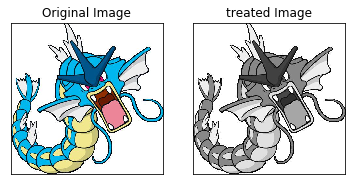

In [3]:
GAUSSIAN_KERNEL_SIZE = 3
GAUSSIAN_SIGMA = 0

DEFAULT_CANNY_SIGMA = 0.33
DEFAULT_IMAGES_TO_CHOOSE = 5

LOWER_SIGMA_THRESHOLD = 10
UPPER_SIGMA_THRESHOLD = 80

MAXIMUM_IMAGE_SIZE = 1920

arquivo = 'arquivo.jpg'

img = cv2.imread(arquivo, -1)

try:
    b,g,r = cv2.split(img)
    img = cv2.merge([r,g,b])
except:
    pass

img2 = cv2.imread(arquivo, 0)

plt.subplot(121),plt.imshow(img, cmap = 'gray');
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img2, cmap = 'gray')
plt.title('treated Image'), plt.xticks([]), plt.yticks([])
plt.show()

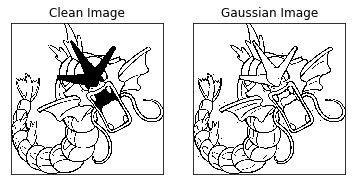

True

In [4]:
(thresh, im_bw) = cv2.threshold(img2, 110, 255, cv2.THRESH_BINARY)
th3 = cv2.adaptiveThreshold(img2,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY,11,10)
#im_bw = cv2.resize(im_bw,(595, 842))


plt.subplot(121),plt.imshow(im_bw, cmap = 'gray');
plt.title('Clean Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(th3, cmap = 'gray');
plt.title('Gaussian Image'), plt.xticks([]), plt.yticks([])
plt.show()
cv2.imwrite('binary_image.bmp', im_bw)

In [5]:
!potrace -s binary_image.bmp -o teste.svg

In [6]:
import re
file = open('teste.svg', 'r')
paths = re.findall(r"<path [^>]*>", file.read())

In [7]:
newpaths = []
for path in paths:
    path_aux = path.replace('\n', ' ')
    path_aux = re.sub(r"<path.*d=\"", '',path_aux)
    path_aux = re.sub(r"\".*/>", '',path_aux)
    newpaths.append(path_aux)

final_path = []
for path in newpaths:
    path_aux = re.findall(r'([MmCcSsLlhHv][^MmCcSsLhlHv]*)', path)
    subpath = []
    for command in path_aux:
        command = command.strip()
        command = command.replace(',', ' ')
        command = command.replace('-', ' -')
        first_letter = command[0]
        last_letter = command[-1]
        command_aux = command.replace(first_letter, first_letter + ' ')
        if last_letter == 'z':
            command_aux = command_aux.replace(last_letter, ' ' + last_letter)
        command_aux = command_aux.strip()
        command_aux = re.split(r'\s+', command_aux)
        subpath.append(command_aux)
    final_path.append(subpath)

In [28]:
coordinates = []
divisor = 25
for path in final_path:
    for command in path:
        if command[0] == 'c':
            if command[-1] == 'z':
                relative_points = [float(i) for i in command[1:-1]]
            else: 
                relative_points = [float(i) for i in command[1:]]
            x_2 = x
            y_2 = y
            for i in range(len(relative_points)//6):
                for t in np.arange(0,1.1,0.1):
                    x = x_2
                    y = y_2
                    x_1 = ((1-t)**3)*(x) + 3*((1-t)**2)*(t)*(x+relative_points[i*6]) + 3*((1-t))*(t**2)*(x+relative_points[i*6 + 2]) + (t**3)*(x+relative_points[i*6+4])
                    y_1 = ((1-t)**3)*(y) + 3*((1-t)**2)*(t)*(y+relative_points[i*6+1]) + 3*((1-t))*(t**2)*(y+relative_points[i*6+3]) + (t**3)*(y+relative_points[i*6+5])
                    y_1 = y_1
                    if(abs(x_1 - x)/divisor >= 2 or abs(y_1 - y)/divisor >= 2):
                        coordinates.append(['L', x_1/divisor, y_1/divisor])
                x_2 = x_1
                y_2 = y_1
                x = x_2
                y = y_1
            if command[-1] == 'z':
                x = x_init
                y = y_init
                coordinates.append(['L', x/divisor, y/divisor])

        elif command[0] == 'M':
            x = float(command[1])
            y = float(command[2])
            x_init = x
            y_init = y
            coordinates.append(['J', x/divisor, y/divisor])

        elif command[0] == 'm':
            x = x + float(command[1])
            y = y + float(command[2])
            x_init = x
            y_init = y
            coordinates.append(['J', x/divisor, y/divisor])

        elif command[0] == 'l':
            if command[-1] == 'z':
                relative_points = [float(i) for i in command[1:-1]]
            else: 
                relative_points = [float(i) for i in command[1:]]
            for i in range(len(relative_points)//2):
                x = x + float(relative_points[i*2])
                y = y + float(relative_points[i*2 + 1])
                coordinates.append(['L', x/divisor, y/divisor])
            if command[-1] == 'z':
                x = x_init
                y = y_init
                coordinates.append(['L', x/divisor, y/divisor])

        elif command[0] == 'h':
            x = x + float(command[1])
            y = y
            coordinates.append(['L', x/divisor, y/divisor])

        elif command[0] == 'H':
            x = float(command[1])
            y = y
            coordinates.append(['L', x/divisor, y/divisor])

        elif command[0] == 'v':
            x = x
            y = y + float(command[1])
            coordinates.append(['L', x/divisor, y/divisor])

In [29]:
df = pd.DataFrame(coordinates)

In [30]:
df.head()

,0,1,2
0,J,65.20000,186.72000
1,L,65.72736,184.48384
2,L,65.84152,184.13988
3,L,65.96000,183.80000
4,L,66.78016,180.87744


In [43]:
df[2] - 50

0       136.72000
1       134.48384
2       134.13988
3       133.80000
4       130.87744
5       128.80716
6       126.48992
7       124.04500
8       121.59168
9       119.24924
10      117.13696
11      115.37412
12      114.08000
13      113.12000
14      114.16000
15      115.06944
16      115.14500
17      115.15936
18      115.11228
19      115.00352
20      114.83284
21      114.60000
22      112.18444
23      111.46016
24      110.60292
25      109.60000
26      106.29088
27      104.57332
28      102.88384
29      101.27500
          ...    
4582      7.52064
4583      8.08256
4584      8.66032
4585      9.24000
4586     11.24832
4587     11.47500
4588     11.59008
4589     11.59284
4590     11.48256
4591     11.25852
4592     10.92000
4593     10.92000
4594     61.24000
4595     59.23444
4596     59.20000
4597     61.24000
4598     55.96000
4599     55.96000
4600     55.96000
4601     52.40000
4602     50.91740
4603     50.86400
4604     50.83940
4605     50.84000
4606     5

In [41]:
f = open("arm_code.mod", "w")
f.write('''MODULE Module1
    !***********************************************************
    !
    ! Module:  Module1
    !
    ! Description:
    !   <Insert description here>
    !
    ! Author: ufabc
    !
    ! Version: 1.0
    !
    !***********************************************************
    
    
    !***********************************************************
    !
    ! Procedure main
    !
    !   This is the entry point of your program
    !
    !***********************************************************
    PROC main()
        !Add your code here
        CONST robtarget p0:=[[557.96,-192.62,509.20],[0.00299687,-0.165444,-0.986215,-0.000502744],[-1,0,0,0],[9E+09,9E+09,9E+09,9E+09,9E+09,9E+09]]\n;
        MoveJ p0, v10, z1, tool0;\n''')

row_ant = False
x = 0
y = 0
for index, row in df.iterrows():
    if row[0] == 'L':
        if row_ant:
            f.write('\tMoveJ Offs(p0,' + str(x) + ',' + str(y) + ', 0), v10, z1, tool0;\n')
        f.write('\tMoveL Offs(p0,' + str(round(row[1], 0)) + ',' + str(round(row[2], 0)) + ', 0), v10, z5, tool0;\n')
        row_ant = False
    else:
        f.write('\tMoveJ Offs(p0,' + str(x) + ',' + str(y) + ', 20), v10, z1, tool0;\n')
        f.write('\tMoveJ Offs(p0,' + str(round(row[1], 0)) + ',' + str(round(row[2], 0)) + ', 20), v10, z1, tool0;\n')
        row_ant = True
    x = round(row[1], 0)
    y = round(row[2], 0)
f.write('\tENDPROC\nENDMODULE')
f.close()

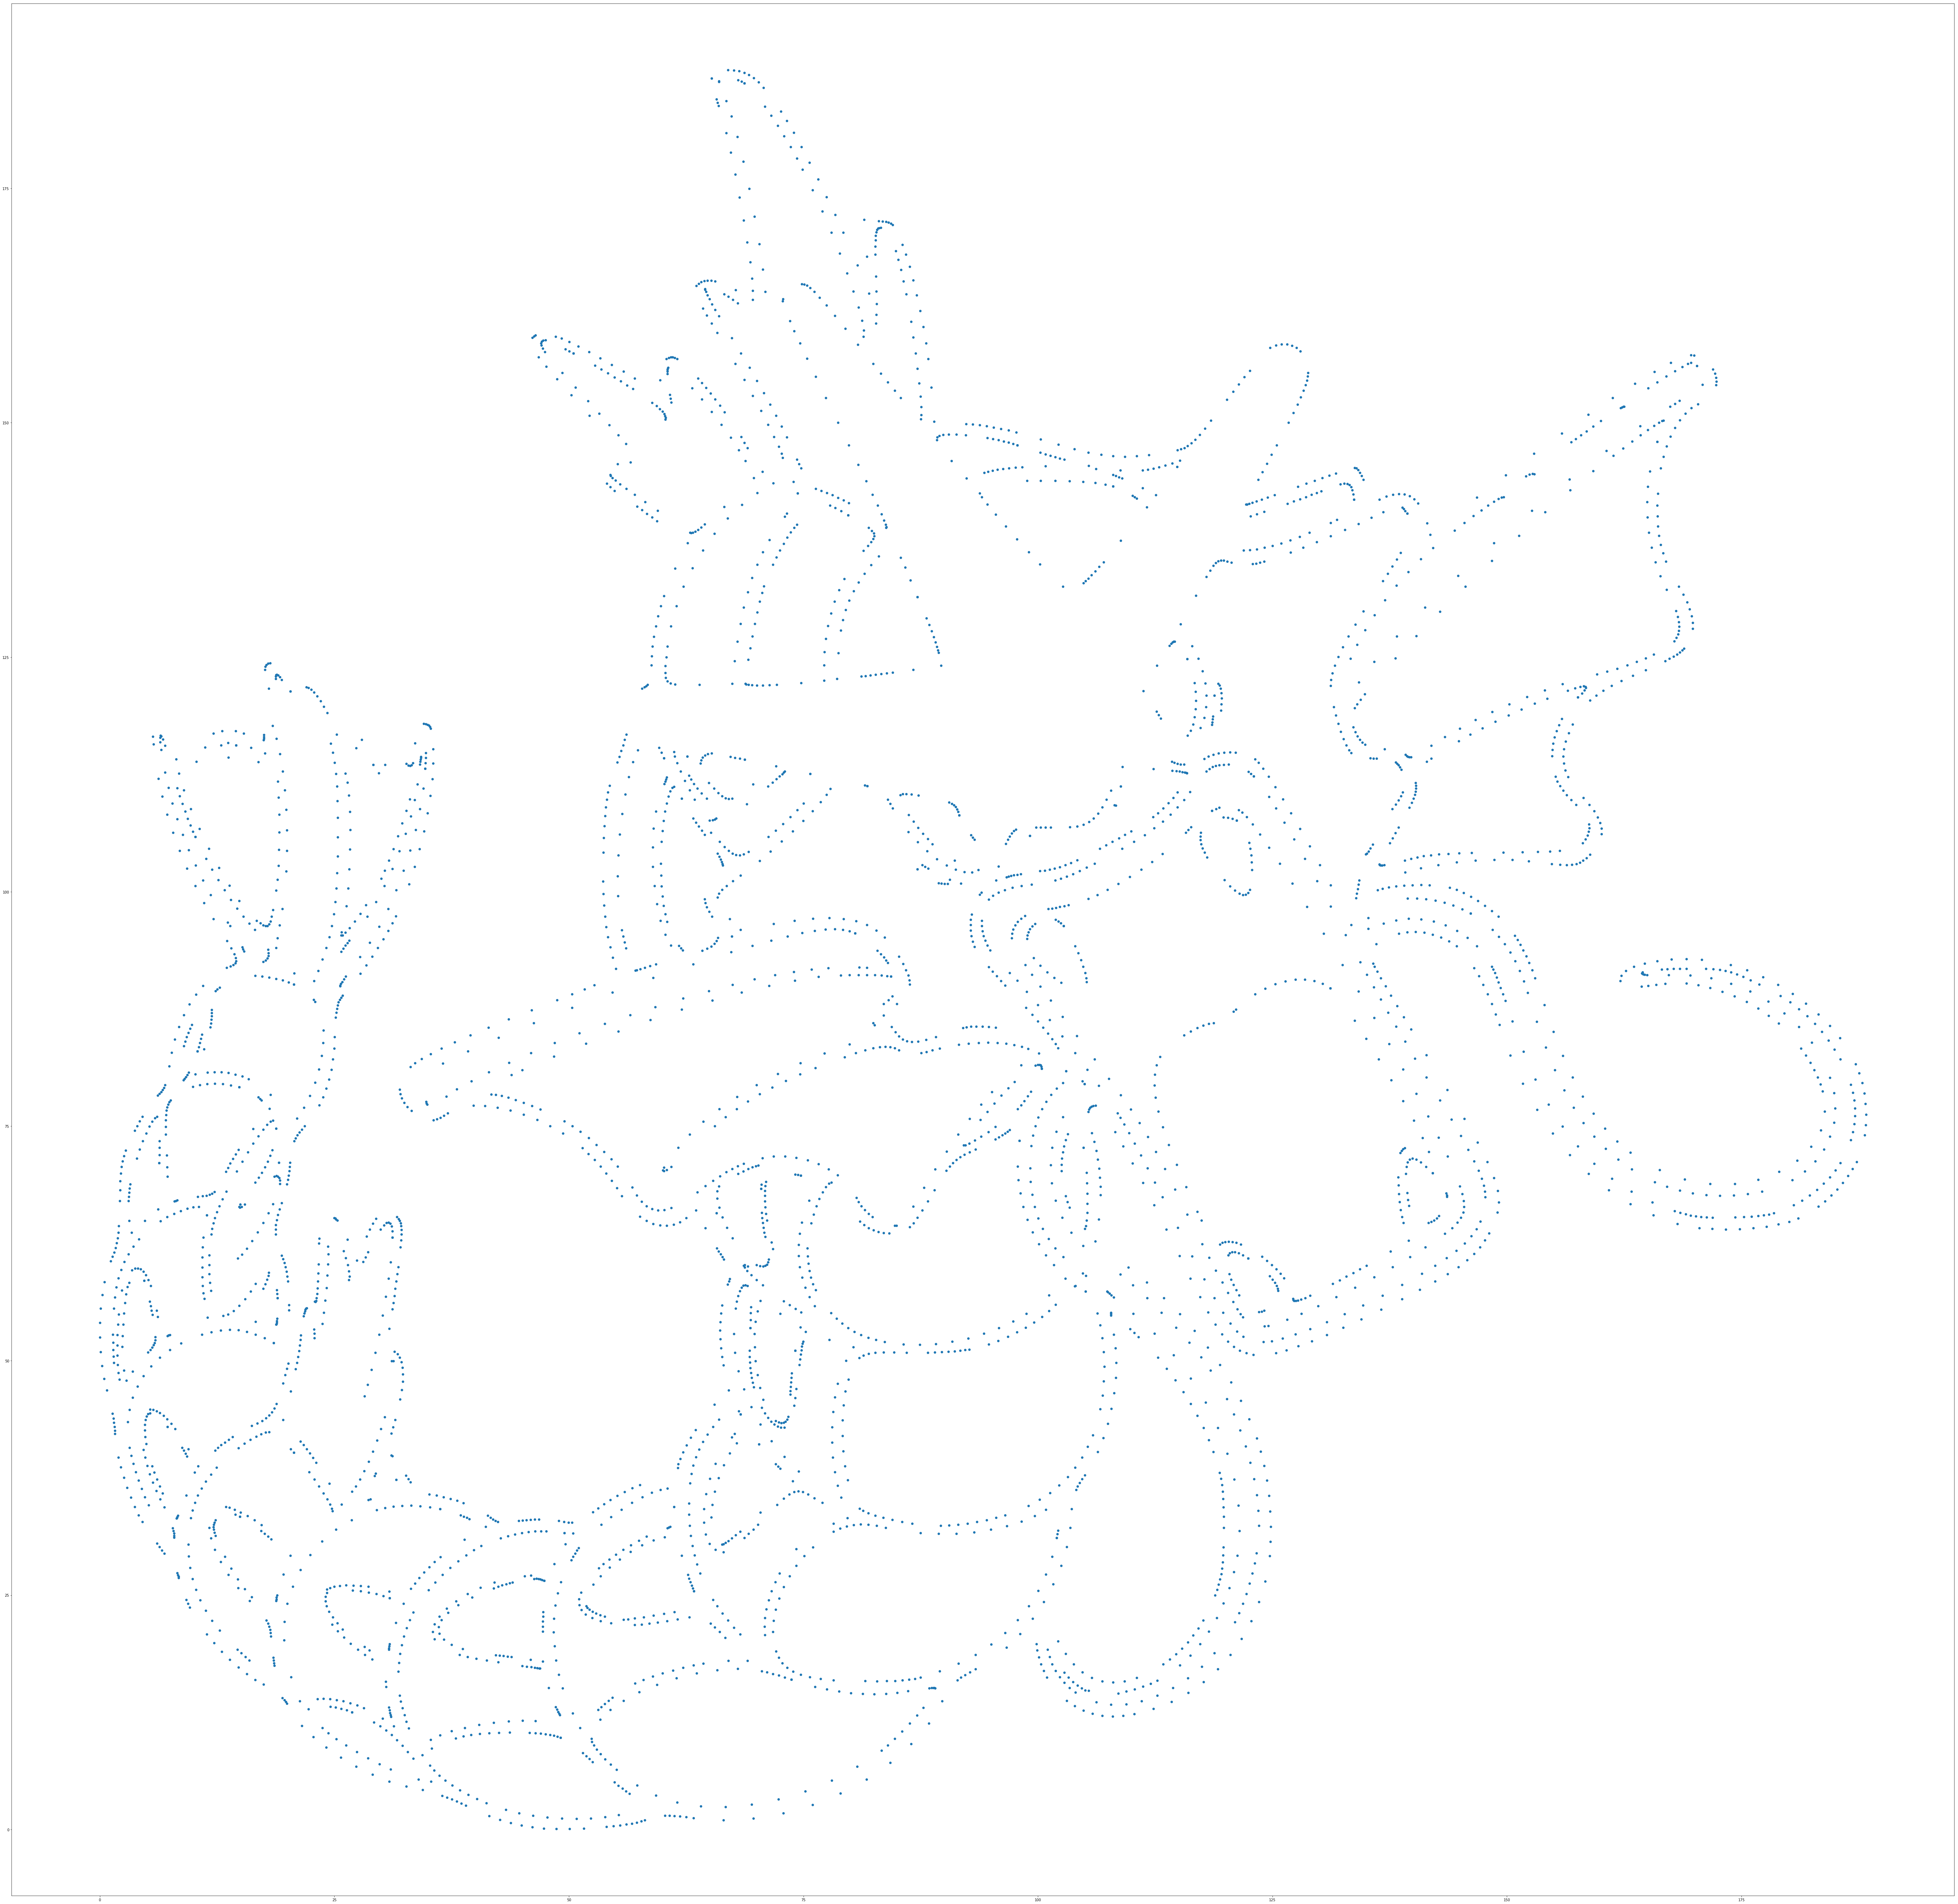

In [44]:
plt.figure(figsize = (100, 100))
plt.scatter(x = df[1], y = df[2])
plt.axis('equal');

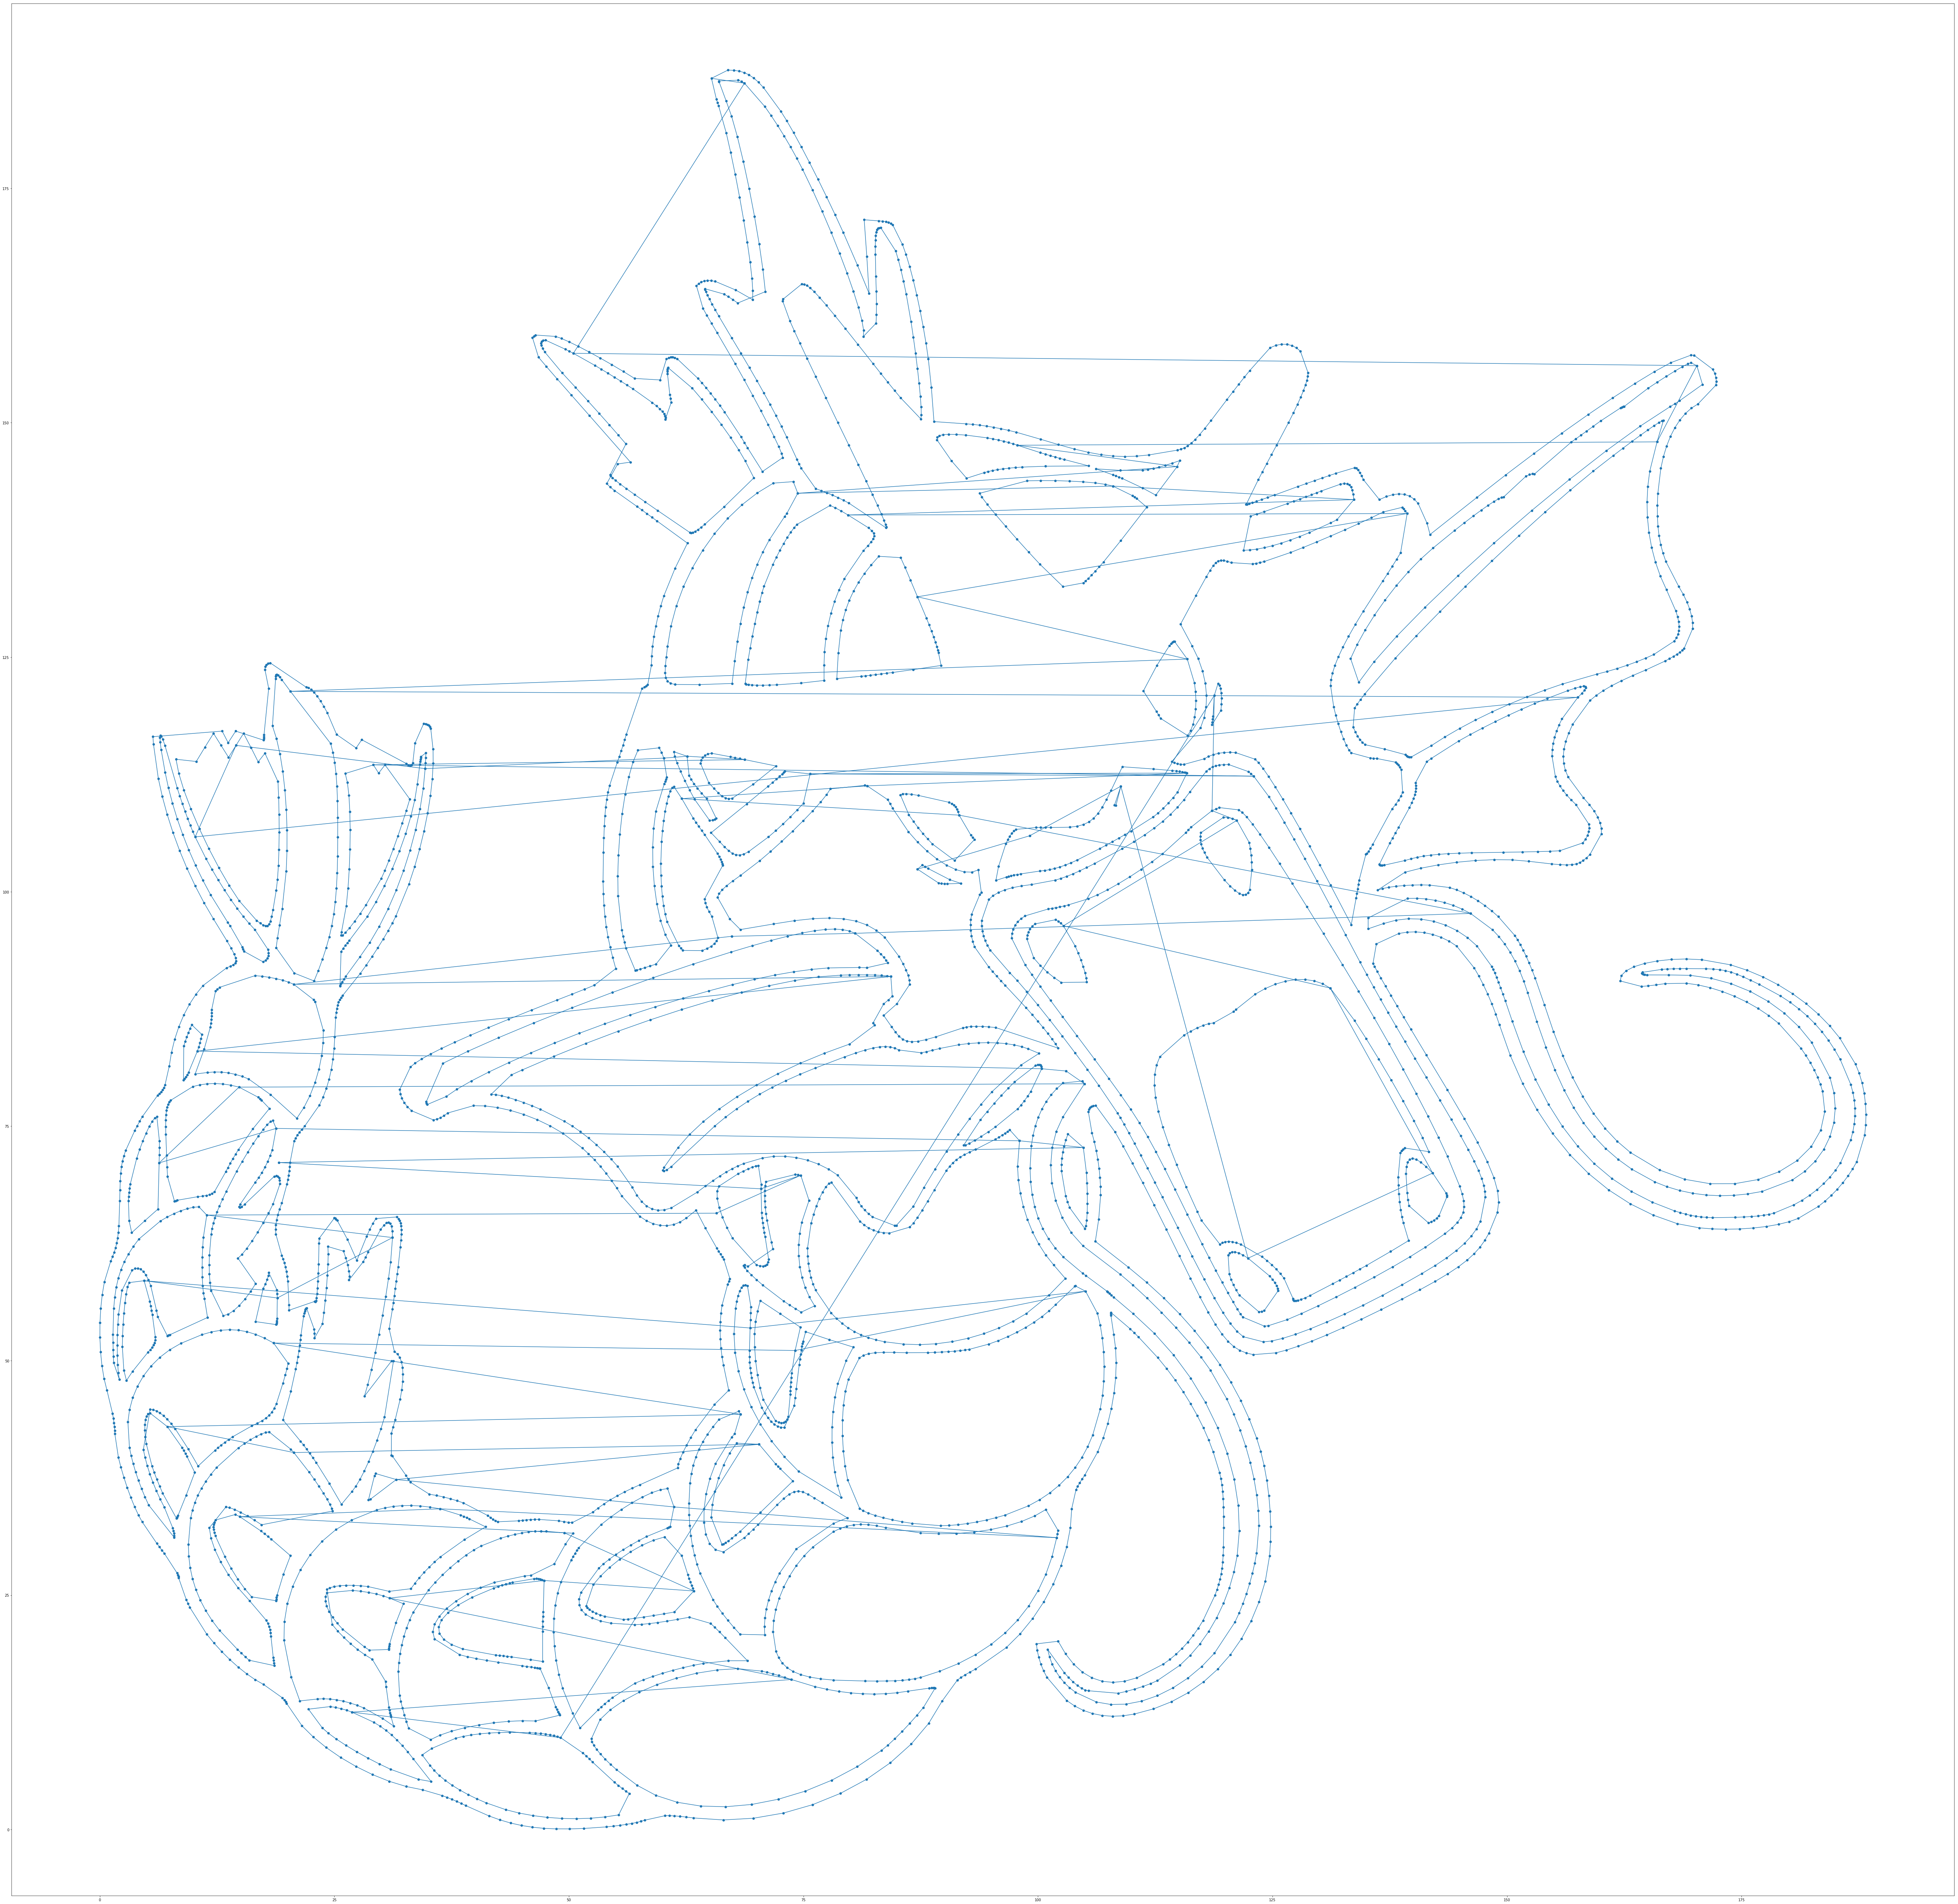

In [45]:
plt.figure(figsize = (100, 100))
plt.plot(df[1], df[2], '-o', )
plt.axis('equal')
plt.show()